In [1]:
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset, SubsetRandomSampler
import pandas as pd
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\litwi\AppData\Local\Temp\ipykernel_27404\3418619313.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
transform = torchvision.transforms.ToTensor()
dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    download=True,
    transform=transform
)
classes2keep = [ 'Trouser','Sneaker', 'Pullover'  ]

wanted_indices = [dataset.class_to_idx[cls] for cls in classes2keep]

images2use = [i for i, (image, label) in enumerate(dataset) if label in wanted_indices]
sampler = SubsetRandomSampler(images2use)

batchsize = 100
data_loader = DataLoader(
    dataset,
    sampler=sampler,
    batch_size=batchsize,
    drop_last=True
)

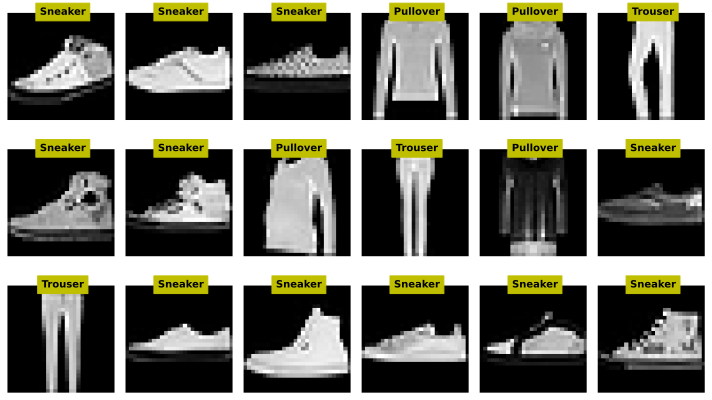

In [8]:
X,y = next(iter(data_loader))

fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):

  pic = torch.squeeze(X.data[i])
  
  label = dataset.classes[y[i]]

  ax.imshow(pic,cmap='gray')
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
class discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)

    def forward(self, X):
        X = F.leaky_relu( self.fc1(X) )
        X = F.leaky_relu( self.fc2(X) )
        X = self.out(X)

        return torch.sigmoid(X)    

In [10]:
class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 784)

    def forward(self, X):
        X = F.leaky_relu(self.fc1(X))
        X = F.leaky_relu(self.fc2(X))
        X = self.out(X)

        return torch.tanh(X)

In [11]:
lossFn = nn.BCELoss()

modelDisctriminator = discriminator().to(device)
modelGenerator = generator().to(device)

d_optim = torch.optim.Adam(modelDisctriminator.parameters(), lr=2e-4)
g_optim = torch.optim.Adam(modelGenerator.parameters(), lr=2e-4)

In [12]:
from tqdm.auto import tqdm

epochs = int(50000/len(data_loader))

losses = np.zeros((epochs*len(data_loader),2))
lossi  = 0

for epoch in tqdm(range(epochs)):

    for data, _ in data_loader:

        data = data.view(batchsize,-1).to(device)
    
        real = torch.ones(batchsize,1).to(device)
        fake = torch.zeros(batchsize,1).to(device)
    
        # ------ Train the discriminator ------
        
        # True images
        pred_real = modelDisctriminator(data)
        d_loss_real = lossFn(pred_real, real)
    
        # False images
        fake_images = modelGenerator( torch.randn(batchsize,64).to(device) )
        pred_fake = modelDisctriminator(fake_images)
        d_loss_fake = lossFn(pred_fake, fake)
    
        # Combine the losses
        d_loss = d_loss_fake+d_loss_real
        losses[lossi, 0] = d_loss.item() # Discriminator loss
    
        d_optim.zero_grad()
        d_loss.backward()
        d_optim.step()
    
    
        # ------ Train the generator ------
        fake_images = modelGenerator( torch.randn(batchsize,64).to(device) )
        pred_fake   = modelDisctriminator(fake_images)
      
        # compute and collect loss and accuracy
        g_loss = lossFn(pred_fake,real)
        losses[lossi,1]  = g_loss.item()
         
        g_optim.zero_grad()
        g_loss.backward()
        g_optim.step()

        lossi += 1
    

C:\Users\litwi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [43:56<00:00,  9.52s/it]


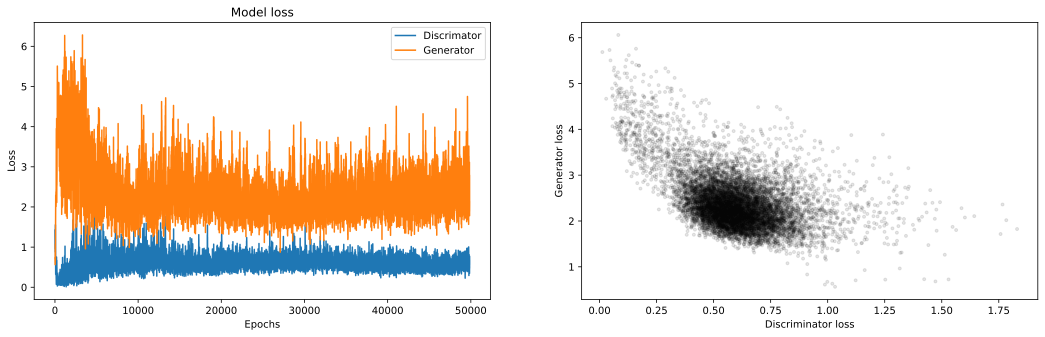

In [13]:
fig,ax = plt.subplots(1,2,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

plt.show()

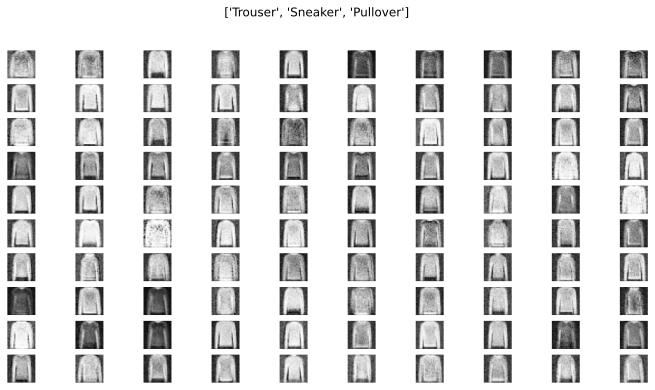

In [23]:
modelGenerator.eval()
fake_data = modelGenerator(torch.randn(100,64).to(device)).cpu()

fig,axs = plt.subplots(10,10,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.suptitle(classes2keep)
plt.show()